In [1]:
import numpy as np
import pandas as pd
import itertools
import warnings
warnings.filterwarnings("ignore")
import io
from plotly.offline import init_notebook_mode, plot,iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)
import matplotlib.pyplot as plt
import plotly.tools as tls#visualization
import plotly.figure_factory as ff#visualization
import seaborn as sns
from sklearn import metrics

In [2]:
nodos = pd.read_csv(
    'https://raw.githubusercontent.com/fgpalacios/diplodatos2020/master/dataset/nodes.csv')

# El segundo archivo posee la relación que existen entre los nodos es decir un nodo persona tiene conocimientos vinculados que es lo que sabe
relaciones = pd.read_csv(
    'https://raw.githubusercontent.com/fgpalacios/diplodatos2020/master/dataset/relationships.csv')

In [3]:
nodos.columns = nodos.columns.str.replace('.', '_')
nodos[nodos.n_age == 0].replace(0, 'NaN')

,n_id,name_node_a,n_type,n_category,n_gender,n_age,n_experience
0,eeca1815ef2efc089f12bfe8c1c4c7f7-c81e728d9d4c2...,Team3,team,NaN,NaN,NaN,NaN
1,73cceb4a6d1f1fd7e91d38c2b906be15-c81e728d9d4c2...,Team2,team,NaN,NaN,NaN,NaN
24,4cd45b1d7210ec9b517bd44c201454ba-a87ff679a2f3e...,Team1,team,NaN,NaN,NaN,NaN
71,6bde45527df4be8bbb24be561e65f751-a87ff679a2f3e...,Data Scientist,skill,NaN,NaN,NaN,NaN
72,720d1c3fee7aef666abe0c50a9a7cde1-a87ff679a2f3e...,DBA,skill,NaN,NaN,NaN,NaN
73,ac894b03f495d68a60f2d786e79aa1e3-a87ff679a2f3e...,Data Architect,skill,NaN,NaN,NaN,NaN
74,7d49add0d0c4fa941e927e85ad5226f2-a87ff679a2f3e...,Developer,skill,NaN,NaN,NaN,NaN
75,4bc67c9e6001ce92edd195848030cb53-a87ff679a2f3e...,Technical Leader,skill,NaN,NaN,NaN,NaN


## PREPARACIÓN DE DATASETS 1 & 2

DATASET1- Preparar un dataset para usar modelos supervisados. Éste debe incluir las personas, los conocimientos, los perfiles (skills) opcional (los teams), que son las que se van a usar para en armar una regresión lineal sobre las personas con los años de experiencias vs el ranking que posee de sus conocimientos.\

In [4]:
df_1 = nodos.merge(relaciones, left_on='n_id', right_on='id_node_a')
df_1 = df_1[df_1['n_type']=='person'][['name_node_a_x', 'name_node_b', 'n_category', 'n_age', 'n_experience']]

DATASET2- Preparar el dataset para el práctico de aprendizaje no supervisado. Éste está orientado a descubrir dentificar los perfiles que puede poseer cada persona, en base a ciertas personas ya clasificadas, por lo que en éste caso debe filtrar éste subconjunto de perfiles (Skills).\

In [5]:
df2 = nodos[nodos.n_type=='skill'].merge(relaciones, left_on='n_id', right_on='id_node_b')
df2 = df2[['name_node_a_x', 'n_type', 'name_node_a_y', 'id_node_a', 'id_node_b']]
df2

,name_node_a_x,n_type,name_node_a_y,id_node_a,id_node_b
0,Data Scientist,skill,Perfiles,dd05195a0be8a3102470e9d6955e49be-c81e728d9d4c2...,6bde45527df4be8bbb24be561e65f751-a87ff679a2f3e...
1,Data Scientist,skill,Fernando,51280652ee54bf9e25636110b859faf5-a87ff679a2f3e...,6bde45527df4be8bbb24be561e65f751-a87ff679a2f3e...
2,Data Scientist,skill,Martin,8ebb5bf7f39a9ec7304a17cdf5063df9-a87ff679a2f3e...,6bde45527df4be8bbb24be561e65f751-a87ff679a2f3e...
3,DBA,skill,Marcelo,a5b6fc8ad5a79c2b57af4137389a7b6b-c81e728d9d4c2...,720d1c3fee7aef666abe0c50a9a7cde1-a87ff679a2f3e...
4,DBA,skill,Perfiles,dd05195a0be8a3102470e9d6955e49be-c81e728d9d4c2...,720d1c3fee7aef666abe0c50a9a7cde1-a87ff679a2f3e...
5,DBA,skill,Jonatan,79b60482d282d7fe48287ef484be2d31-a87ff679a2f3e...,720d1c3fee7aef666abe0c50a9a7cde1-a87ff679a2f3e...
6,DBA,skill,Lucas,6bb28c0af81044a5f2bf023eb7f253e2-a87ff679a2f3e...,720d1c3fee7aef666abe0c50a9a7cde1-a87ff679a2f3e...
7,DBA,skill,Gastón,f6b8790fd8dcb51f4ccec2e19f6db824-a87ff679a2f3e...,720d1c3fee7aef666abe0c50a9a7cde1-a87ff679a2f3e...
8,Data Architect,skill,Perfiles,dd05195a0be8a3102470e9d6955e49be-c81e728d9d4c2...,ac894b03f495d68a60f2d786e79aa1e3-a87ff679a2f3e...
9,Developer,skill,Marcela,1ae7f988daa7541df8d9eba692e3949d-c81e728d9d4c2...,7d49add0d0c4fa941e927e85ad5226f2-a87ff679a2f3e...


In [6]:
t = nodos[nodos.n_type=='technologies'].merge(relaciones)
t = t[['n_id', 'name_node_a', 'id_node_b']]

df2.merge(t, left_on='id_node_b' , right_on='id_node_b')
display(df2)

,name_node_a_x,n_type,name_node_a_y,id_node_a,id_node_b
0,Data Scientist,skill,Perfiles,dd05195a0be8a3102470e9d6955e49be-c81e728d9d4c2...,6bde45527df4be8bbb24be561e65f751-a87ff679a2f3e...
1,Data Scientist,skill,Fernando,51280652ee54bf9e25636110b859faf5-a87ff679a2f3e...,6bde45527df4be8bbb24be561e65f751-a87ff679a2f3e...
2,Data Scientist,skill,Martin,8ebb5bf7f39a9ec7304a17cdf5063df9-a87ff679a2f3e...,6bde45527df4be8bbb24be561e65f751-a87ff679a2f3e...
3,DBA,skill,Marcelo,a5b6fc8ad5a79c2b57af4137389a7b6b-c81e728d9d4c2...,720d1c3fee7aef666abe0c50a9a7cde1-a87ff679a2f3e...
4,DBA,skill,Perfiles,dd05195a0be8a3102470e9d6955e49be-c81e728d9d4c2...,720d1c3fee7aef666abe0c50a9a7cde1-a87ff679a2f3e...
5,DBA,skill,Jonatan,79b60482d282d7fe48287ef484be2d31-a87ff679a2f3e...,720d1c3fee7aef666abe0c50a9a7cde1-a87ff679a2f3e...
6,DBA,skill,Lucas,6bb28c0af81044a5f2bf023eb7f253e2-a87ff679a2f3e...,720d1c3fee7aef666abe0c50a9a7cde1-a87ff679a2f3e...
7,DBA,skill,Gastón,f6b8790fd8dcb51f4ccec2e19f6db824-a87ff679a2f3e...,720d1c3fee7aef666abe0c50a9a7cde1-a87ff679a2f3e...
8,Data Architect,skill,Perfiles,dd05195a0be8a3102470e9d6955e49be-c81e728d9d4c2...,ac894b03f495d68a60f2d786e79aa1e3-a87ff679a2f3e...
9,Developer,skill,Marcela,1ae7f988daa7541df8d9eba692e3949d-c81e728d9d4c2...,7d49add0d0c4fa941e927e85ad5226f2-a87ff679a2f3e...


In [7]:
a = nodos[nodos['n_type']=='technologies']
techs = a['name_node_a'].unique()
a = df2.merge(df_1, left_on='name_node_a_y', right_on='name_node_a_x')
display(a)

,name_node_a_x_x,n_type,name_node_a_y,id_node_a,id_node_b,name_node_a_x_y,name_node_b,n_category,n_age,n_experience
0,Data Scientist,skill,Fernando,51280652ee54bf9e25636110b859faf5-a87ff679a2f3e...,6bde45527df4be8bbb24be561e65f751-a87ff679a2f3e...,Fernando,Data Scientist,semi-senior,28.0,4.0
1,Data Scientist,skill,Fernando,51280652ee54bf9e25636110b859faf5-a87ff679a2f3e...,6bde45527df4be8bbb24be561e65f751-a87ff679a2f3e...,Fernando,AWS Lambda,semi-senior,28.0,4.0
2,Data Scientist,skill,Fernando,51280652ee54bf9e25636110b859faf5-a87ff679a2f3e...,6bde45527df4be8bbb24be561e65f751-a87ff679a2f3e...,Fernando,phyton,semi-senior,28.0,4.0
3,Data Scientist,skill,Fernando,51280652ee54bf9e25636110b859faf5-a87ff679a2f3e...,6bde45527df4be8bbb24be561e65f751-a87ff679a2f3e...,Fernando,Docker,semi-senior,28.0,4.0
4,Data Scientist,skill,Fernando,51280652ee54bf9e25636110b859faf5-a87ff679a2f3e...,6bde45527df4be8bbb24be561e65f751-a87ff679a2f3e...,Fernando,Kubernetes,semi-senior,28.0,4.0
...,...,...,...,...,...,...,...,...,...,...
101,Technical Leader,skill,Lionel,bcb93d9680b08656367b3682a9b4c127-c81e728d9d4c2...,4bc67c9e6001ce92edd195848030cb53-a87ff679a2f3e...,Lionel,Oracle,semi-senior,35.0,3.0
102,Technical Leader,skill,Lionel,bcb93d9680b08656367b3682a9b4c127-c81e728d9d4c2...,4bc67c9e6001ce92edd195848030cb53-a87ff679a2f3e...,Lionel,Google cloud,semi-senior,35.0,3.0
103,Technical Leader,skill,Lionel,bcb93d9680b08656367b3682a9b4c127-c81e728d9d4c2...,4bc67c9e6001ce92edd195848030cb53-a87ff679a2f3e...,Lionel,Docker,semi-senior,35.0,3.0
104,Technical Leader,skill,Lionel,bcb93d9680b08656367b3682a9b4c127-c81e728d9d4c2...,4bc67c9e6001ce92edd195848030cb53-a87ff679a2f3e...,Lionel,neo4j,semi-senior,35.0,3.0


# Dataset para Problema de Clasificación Binario

Si bien nuestro problema original es uno de clasificación múltiple, comenzaremos por tratarlo como un problema de clasificación binario, en donde nuestro objetivo será:

0 = Corresponde a una persona con poca experiencia (person_category = junior o person_category = semi-senior

1 = Corresponde a una persona con poca experiencia (person_category = senior

Es decir, queremos identificar las personas con alto perfil de las que tienen poco . En base a esta definición, deben transformar el dataset para adaptarlo a un problema de clasifiación binario.

¿Cómo luce ahora el balance de clases? ¿Tomarán alguna decisión al respecto?

In [8]:
ds_bin = df_1
ds_bin['n_category'].unique()

array(['junior', 'senior', 'semi-senior'], dtype=object)

# Dataset binarizado
Generamos dummies para la columna n_categoria. Si nos quedamos únicamente con la clasificación "Senior SI/NO" habremos binarizado el dataset.
Si la persona corresponde a la categoria senior se le asigna un 1, caso contrario se le asigna un 0.

In [9]:
aux = ds_bin['n_category'].str.get_dummies()
display(aux)

,junior,semi-senior,senior
8,1,0,0
9,1,0,0
10,1,0,0
11,1,0,0
12,1,0,0
...,...,...,...
118,0,0,1
119,0,0,1
120,0,0,1
121,0,0,1


In [10]:
ds_bin = pd.concat([ds_bin, aux], axis=1)
ds_bin = ds_bin.drop(['junior','semi-senior'], axis=1)
display(ds_bin)

,name_node_a_x,name_node_b,n_category,n_age,n_experience,senior
8,Marcela,Developer,junior,23.0,3.0,0
9,Marcela,windows,junior,23.0,3.0,0
10,Marcela,Linux,junior,23.0,3.0,0
11,Marcela,MySQL,junior,23.0,3.0,0
12,Marcela,phyton,junior,23.0,3.0,0
...,...,...,...,...,...,...
118,Martin,Data Scientist,senior,34.0,5.0,1
119,Martin,Vertica,senior,34.0,5.0,1
120,Martin,SQL Server,senior,34.0,5.0,1
121,Martin,phyton,senior,34.0,5.0,1


# Label encoder
Codificamos las columnas name_node_a_x y name_node_b para poder compatibilizar nuestro dataset con scikitlear

In [11]:
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()

for column in ['name_node_a_x', 'name_node_b', 'n_category']:
    ds_bin[column] = lb_make.fit_transform(ds_bin[column])
ds_bin.head()

,name_node_a_x,name_node_b,n_category,n_age,n_experience,senior
8,9,4,0,23.0,3.0,0
9,9,32,0,23.0,3.0,0
10,9,11,0,23.0,3.0,0
11,9,13,0,23.0,3.0,0
12,9,29,0,23.0,3.0,0


In [12]:
from sklearn.utils import shuffle
ds_bin = shuffle(ds_bin)
ds_bin['senior'] = pd.to_numeric(ds_bin['senior'], downcast='float')
ds_bin

,name_node_a_x,name_node_b,n_category,n_age,n_experience,senior
45,6,28,1,35.0,3.0,0.0
82,4,11,2,33.0,7.0,1.0
27,1,20,2,44.0,11.0,1.0
24,1,5,2,44.0,11.0,1.0
41,6,26,1,35.0,3.0,0.0
...,...,...,...,...,...,...
20,1,17,2,44.0,11.0,1.0
15,1,16,2,44.0,11.0,1.0
106,0,9,1,27.0,3.0,0.0
54,13,22,0,24.0,2.0,0.0


# Scitkit Learn
Implementamos scitkit learn para el pipeline tradicional: preparación dataset en train/test, selección de modelo, entrenamiento, validación y determinación de accuracy.

In [13]:
from sklearn.model_selection import train_test_split
X, y = ds_bin[['n_age', 'n_experience']], ds_bin['senior']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)
#Chequeamos shape para comprobar que esta todo en orden
X_train.shape, X_test.shape

((84, 2), (22, 2))

## Aplicación de Modelos de Clasificación
Una vez finalizada la etapa de preprocesamiento, se propone implementar diferentes modelos de clasificación para ambos datasets, utilizando la librería Scikit-Learn:

1. Perceptron. Utilizar el método Stochastic Gradient Descent (Recuerden mezclar aleatoriamente los datos antes de cada iteración)
2. K Nearest Neighbors ó K Vecinos Más Cercanos
3. Regresión Lineal.
4. Regresión Logística. Utilizar el método Stochastic Gradient Descent (Recuerden mezclar aleatoriamente los datos antes de cada iteración)
Para cada uno de ellos, se pide responder las siguientes consignas:

Utilizar dos features para graficar las clases y la frontera de decisión, siempre que sea posible.
Agregar vector de Bias, cuando lo crean pertinente. Cuándo hace falta y cuándo no? Por qué?
Obtener accuracy o exactitud.
De estos tres tipos de modelos, cuál creen que es el más adecuado para nuestro caso de aplicación?

Elegir el modelo que consideren que mejor aplica a nuestro problema. Para ello, recuerden que los pasos a seguir en la selección pueden esquematizarse como sigue:

1. Descripción de la Hipótesis
¿Cuál es nuestro problema? ¿Cómo se caracteriza? ¿Cuál es la hipótesis?

2. Selección de Regularizador
¿Utilizarán algún regularizador?¿Cuál?

3. Selección de Función de Costo
¿Cuál será la función de costo utilizada?

4. Justificación de las Selecciones
¿Por qué eligieron el modelo, el regularizador y la función de costo previas?

Finalmente, para el modelo selecionado:

Utilizar el método Grid Search, o de búsqueda exahustiva, con cross-validation para profundizar en la búsqueda y selección de hiperparámetros.
Calcular métricas sobre el conjunto de entrenamiento y de evaluación para los mejores parámetros obtenidos:
Accuracy o exactitud
Reporte de clasificación
Confusion matrix o matriz de confusión (graficar como heatmap)
Curva ROC y área bajo la curva (AUC).
Entregables
El entregable de este práctico consiste en esta misma Notebook, pero con el preprocesamiento aplicado y los modelos implementados, agregando las explicaciones que crean pertinentes y las decisiones tomadas, en caso de corresponder.

In [14]:
import utils


## 1.Perceptron

In [15]:
from sklearn.linear_model import Perceptron
model = Perceptron(tol=1e-3, random_state=0)

model.fit(X_train, y_train)

Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
           fit_intercept=True, max_iter=1000, n_iter_no_change=5, n_jobs=None,
           penalty=None, random_state=0, shuffle=True, tol=0.001,
           validation_fraction=0.1, verbose=0, warm_start=False)

In [16]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [17]:
from sklearn.metrics import classification_report

print(f"Report para y_train")
print(classification_report(y_train, y_train_pred))
print(f"\n*2")
print(f"Report para y_test")
print(classification_report(y_test, y_test_pred))

Report para y_train
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        47
         1.0       1.00      1.00      1.00        37

    accuracy                           1.00        84
   macro avg       1.00      1.00      1.00        84
weighted avg       1.00      1.00      1.00        84


*2
Report para y_test
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        14
         1.0       1.00      1.00      1.00         8

    accuracy                           1.00        22
   macro avg       1.00      1.00      1.00        22
weighted avg       1.00      1.00      1.00        22



Nueva implementacion de sklearn sobre perceptrón dentro del módulo de SGD.

In [18]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [19]:
# Always scale the input. The most convenient way is to use a pipeline. 
model = make_pipeline(StandardScaler(),
                    SGDClassifier(loss="perceptron", eta0=1, learning_rate="constant", penalty=None))

model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('sgdclassifier',
                 SGDClassifier(alpha=0.0001, average=False, class_weight=None,
                               early_stopping=False, epsilon=0.1, eta0=1,
                               fit_intercept=True, l1_ratio=0.15,
                               learning_rate='constant', loss='perceptron',
                               max_iter=1000, n_iter_no_change=5, n_jobs=None,
                               penalty=None, power_t=0.5, random_state=None,
                               shuffle=True, tol=0.001, validation_fraction=0.1,
                               verbose=0, warm_start=False))],
         verbose=False)

In [20]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [21]:
print(f"Report para y_train")
print(classification_report(y_train, y_train_pred))
print(f"\n*2")
print(f"Report para y_test")
print(classification_report(y_test, y_test_pred))

Report para y_train
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        47
         1.0       1.00      1.00      1.00        37

    accuracy                           1.00        84
   macro avg       1.00      1.00      1.00        84
weighted avg       1.00      1.00      1.00        84


*2
Report para y_test
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        14
         1.0       1.00      1.00      1.00         8

    accuracy                           1.00        22
   macro avg       1.00      1.00      1.00        22
weighted avg       1.00      1.00      1.00        22



In [22]:
#Dado que tanto la edad como la expriencia vienen dadas en enteros, cambiamos de float a int
X_train['n_experience']=np.asarray(X_train['n_experience'], dtype=int)
X_train['n_age']=np.asarray(X_train['n_age'], dtype=int)
X_test['n_experience']=np.asarray(X_test['n_experience'], dtype=int)
X_test['n_age']=np.asarray(X_test['n_age'], dtype=int)

In [23]:
#Buscamos armar una matriz X_test_plot a partir de X_test['n_age'] y X_test['n_experience'] para graficar.
#Primero definimos una matriz nula
X_test_plot=np.zeros((2,22))
#Luego, ingresamos los datos supra mencionados
X_test_plot[0,:]=np.matrix( X_test['n_age'])
X_test_plot[1,:]=np.matrix(X_test['n_experience'])

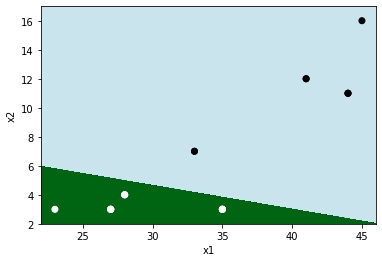

In [24]:
utils.plot_decision_boundary(lambda x: model.predict(x), X_test_plot, y_test)

## 2. K Nearest Neighbors ó K Vecinos Más Cercanos

In [25]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=3)

model.fit(X, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [26]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [27]:
print(f"Report para y_train")
print(classification_report(y_train, y_train_pred))
print(f"\n*2")
print(f"Report para y_test")
print(classification_report(y_test, y_test_pred))

Report para y_train
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        47
         1.0       1.00      1.00      1.00        37

    accuracy                           1.00        84
   macro avg       1.00      1.00      1.00        84
weighted avg       1.00      1.00      1.00        84


*2
Report para y_test
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        14
         1.0       1.00      1.00      1.00         8

    accuracy                           1.00        22
   macro avg       1.00      1.00      1.00        22
weighted avg       1.00      1.00      1.00        22



## 3. Regresión Lineal.

In [28]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
regr = LinearRegression()

regr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [29]:
y_train_pred = regr.predict(X_train)
y_test_pred = regr.predict(X_test)

Coefficients: 
 [0.01636999 0.07553842]
Mean squared error: 0.05
Variance score: 0.78


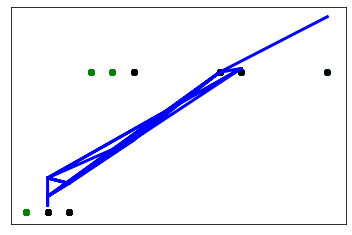

In [30]:
# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_test_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, y_test_pred))

# Plot outputs
plt.scatter(X_train['n_experience'], y_train,  color='green')
plt.scatter(X_test['n_experience'], y_test,  color='black')
plt.plot(X_test['n_experience'], y_test_pred, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

## 4. Regresión Logística.

In [31]:
model = SGDClassifier(loss="log", eta0=1, learning_rate="constant", penalty=None)

model.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=1, fit_intercept=True,
              l1_ratio=0.15, learning_rate='constant', loss='log',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty=None,
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [32]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [33]:
print(f"Report para y_train")
print(classification_report(y_train, y_train_pred))
print(f"\n*2")
print(f"Report para y_test")
print(classification_report(y_test, y_test_pred))

Report para y_train
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        47
         1.0       1.00      1.00      1.00        37

    accuracy                           1.00        84
   macro avg       1.00      1.00      1.00        84
weighted avg       1.00      1.00      1.00        84


*2
Report para y_test
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        14
         1.0       1.00      1.00      1.00         8

    accuracy                           1.00        22
   macro avg       1.00      1.00      1.00        22
weighted avg       1.00      1.00      1.00        22



In [34]:
display(model.coef_)
bound = X_test.dot(model.coef_.T)
print(bound)

array([[-21.85849746, 153.63214893]])

               0
52   -304.150964
105  -129.282985
63    947.387391
27    728.179750
93      2.490667
81    354.094626
117  -129.282985
14    728.179750
111  -129.282985
13    -41.848995
102  -129.282985
112  -129.282985
98      2.490667
39   -304.150964
42   -304.150964
101     2.490667
49   -304.150964
66    947.387391
44   -304.150964
85    354.094626
20    728.179750
33   1474.481997


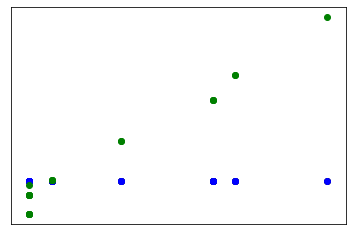

In [35]:
# Plot outputs
#plt.scatter(X_train['n_experience'], y_train,  color='green')
plt.scatter(X_test['n_experience'], y_test,  color='black')
plt.scatter(X_test['n_experience'], y_test_pred, color='blue')
plt.scatter(X_test['n_experience'],bound.T, color='green')


plt.xticks(())
plt.yticks(())

plt.show()

Param Grid aplicado sobre el modelo de Regresión Logística

In [36]:
param_grid = {
    'loss': ['log'],
    'penalty':['None', 'l2'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'eta0':[0.00000001, 0.000001, 0.0001, 0.01]
}

## ParameterGrid

In [37]:
from sklearn.model_selection import ParameterGrid

for params in ParameterGrid(param_grid):
 #   print(params)
    model = SGDClassifier(**params, random_state=0)

## GridSearch
Análisis con GridSearch para regresión logística

In [38]:
from sklearn.model_selection import GridSearchCV

model = model = SGDClassifier(random_state=0)

cv = GridSearchCV(model, param_grid, scoring='accuracy', cv=3)
cv.fit(X, y);

In [39]:
results = cv.cv_results_
params = results['params']
mean = results['mean_test_score']
std = results['std_test_score']
rank = results['rank_test_score']

print("loss\penalty\alpha\learning_rate\eta0\t| mean\tstd\trank")
for p, m, s, r in zip(params, mean, std, rank):
    print(f"{p['loss']}\t{p['penalty']}\t{p['alpha']}\t{p['learning_rate']}\t{p['eta0']}\t| {m:0.2f}\t{s:0.2f}\t{r}")

loss\penaltylpha\learning_rate\eta0	| mean	std	rank
log	None	0.0001	constant	1e-08	| 0.42	0.01	31
log	l2	0.0001	constant	1e-08	| 0.42	0.01	31
log	None	0.0001	invscaling	1e-08	| 0.42	0.01	31
log	l2	0.0001	invscaling	1e-08	| 0.42	0.01	31
log	None	0.0001	adaptive	1e-08	| 0.42	0.01	31
log	l2	0.0001	adaptive	1e-08	| 0.42	0.01	31
log	None	0.0001	constant	1e-06	| 0.42	0.01	31
log	l2	0.0001	constant	1e-06	| 0.42	0.01	31
log	None	0.0001	invscaling	1e-06	| 0.42	0.01	31
log	l2	0.0001	invscaling	1e-06	| 0.42	0.01	31
log	None	0.0001	adaptive	1e-06	| 0.42	0.01	31
log	l2	0.0001	adaptive	1e-06	| 0.42	0.01	31
log	None	0.0001	constant	0.0001	| 0.91	0.05	16
log	l2	0.0001	constant	0.0001	| 0.91	0.05	16
log	None	0.0001	invscaling	0.0001	| 0.42	0.01	31
log	l2	0.0001	invscaling	0.0001	| 0.42	0.01	31
log	None	0.0001	adaptive	0.0001	| 0.91	0.05	16
log	l2	0.0001	adaptive	0.0001	| 0.91	0.05	16
log	None	0.0001	constant	0.01	| 0.91	0.05	16
log	l2	0.0001	constant	0.01	| 0.93	0.03	7
log	None	0.0001	invscaling	0.01	

Los mejores modelos tienen un accuracy promedio del 0.97 con una stdv de 0.2, Sin usar función de pérdida, y con una tasa adaptativa de la learnning rate.